In [1]:
from matplotlib import pyplot as plt
import numpy as np  
from scipy import ndimage
import cv2

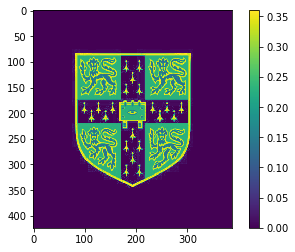

In [9]:
fpath = r'camb_shield.npy'
im = np.load(fpath)
im = np.max(im) - im
im = np.pad(im,75)
plt.imshow(im)
im.shape
plt.colorbar()

In [2]:
def rotate(im,a=0):
    return ndimage.rotate(im,a,order=1,reshape=False)

def project(im,a=0):
    if a != 0:
        imr = rotate(im,a)
    if a == 0:
        imr = im
    return np.sum(imr,axis=0)

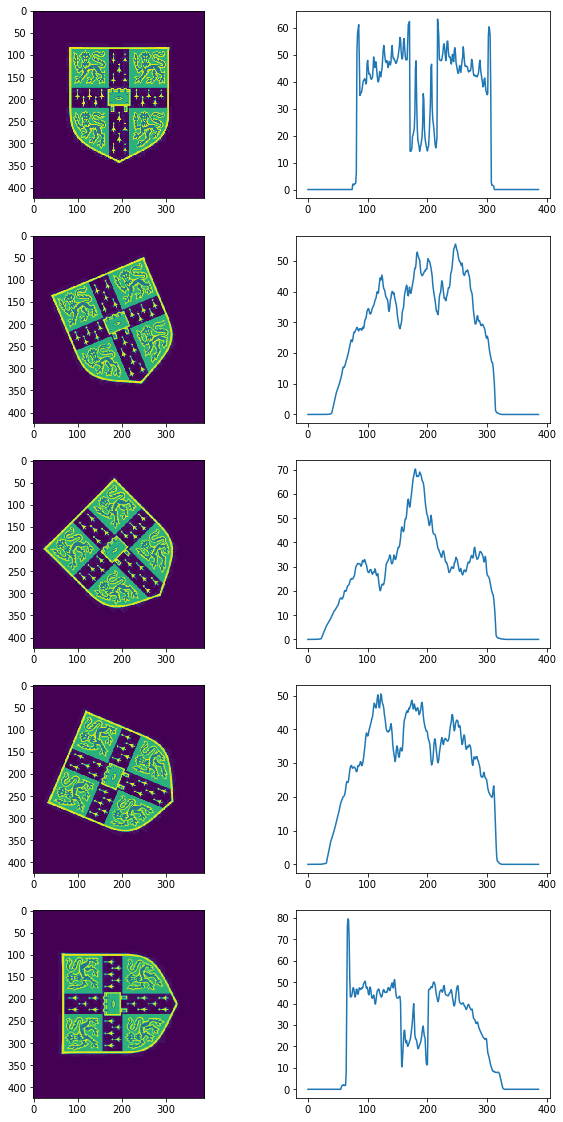

In [11]:
angles = np.linspace(0,90,num=5)

f,axs = plt.subplots(nrows=5,ncols=2,figsize=(10,20))
for i, a in enumerate(angles):
    imr = rotate(im,a=a)
    imp = project(imr)
    
    axs[i,0].imshow(imr)
    axs[i,1].plot(imp)

Text(0, 0.5, 'Projection angle \n (ccw from vertical) \n / degrees')

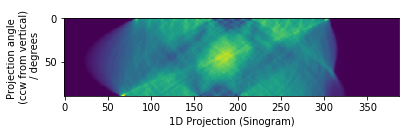

In [14]:
ps = []
for a in range(90):
    p = project(im,a)
    ps.append(p)
plt.imshow(ps)
plt.xlabel('1D Projection (Sinogram)')
plt.ylabel('Projection angle \n (ccw from vertical) \n / degrees')

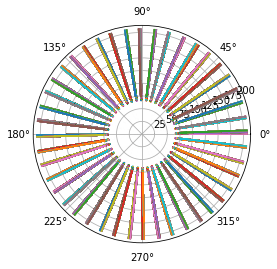

In [133]:
a = 0.0
p = project(im,a)
#plt.polar(np.ones_like(p)*a,p)
for a in range(90):
    plt.polar(np.ones_like(ps)*a,ps)
plt.show()

In [15]:
%matplotlib inline
# plt.figure(figsize=(5,5))
# plt.rcParams.update({'font.size': 12})
# ax = plt.gca()

d = 100
n = 100
lmin = 1
num = 20

def plot_slices(d=100,n=100,lmin=1,num=20, save_path = False,amax=90):
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 12})
    ax = plt.gca()

    # Create uniform image of ones
    im = np.ones((n,n))
    
    # angle projection range
    angles = np.linspace(-amax,amax,num=num)
    
    # width of image
    n = np.shape(im)[1]
    
    # initialise fourier image
    final = np.zeros((n,n))
    
    # loop over angles and add each projection to fourier image
    for a in angles:
        p = project(im,a)
        fs = np.zeros((n,n))
        
        # central slice becomes projection data
        centre = int(n/2)
        fs[centre,:] = p
        fsr = rotate(fs,a)
        final += fsr

    #pixel width real space
    px_im = d/n
    #pixel width in fourier space
    px_ft = 1/d #1/(n*px_im)
    # Total number of pixels needed for highest res
    N = 1/(lmin*px_ft)#1/(px_im*px_ft)
    # missing pixels in Fourier space
    missing = int((N-n)/2)
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)])
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    #Crowther
    fmax = num/(np.pi * d)

    plt.imshow(final,vmax=1e-5,cmap='Greys_r',extent=extent)
    c = plt.Circle([0,0],radius=fmax,color='r',fill=False)
    ax.add_patch(c)
    plt.xlabel('k$_x$ / nm$^{-1}$')
    plt.ylabel('k$_y$ / nm$^{-1}$')
    plt.title('Size: %i nm x %i nm, Sampling: %i x %i, \n Pixel width: %.2f nm, %i projections' % (d,d,n,n,d/n,num))
    
    if save_path != False:
        plt.savefig(save_path)

In [3]:
def plot_slices2(d=100,n=200,lmin=1,num=30, save_path = False,amax=90):
    # Note there will be some innaccuracy due to rounding projection width to int
    # the higher the FS resolution the less noticable, >10 is good enough
    # lmin is real space width of pixel at highest res of interest
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 15})
    ax = plt.gca()

    # Create uniform image of ones
    im = np.ones((n,n))
    
    # angle projection range
    angles = np.linspace(-amax,amax,num=num)
    
    # width of image
    n = np.shape(im)[1]
    
    # initialise fourier image
    # Needs to be at least enough to resolve slice width
    N = 1000
    final = np.zeros((N,N))
    
    centre = int(N/2)
    
    rpx = d/n
    fpx = 1/rpx / N
    width = 1/d
    width_i = width/fpx
    print('--%.1f-- should be >=10, else your FS display resolution is not high enough)' % width_i)
    print(int(width_i/2)*2,width_i)
    
    # loop over angles and add each projection to fourier image
    for a in angles:
        # project image
        p = project(im,a)
        # reshape projection to desired shape
        p_resize = cv2.resize(p,dsize=(N,int(width_i/2)*2))
        
        fs = np.zeros((N,N))
        
        # central slice becomes projection data
        
        
        fs[centre-int(width_i/2):centre+int(width_i/2),:] = p_resize
        fsr = rotate(fs,a)
        final += fsr

    # display width no. at desired res in FS
    n_fdw = 1/lmin / fpx
    missing = int(n_fdw-N)
        
#     #pixel width real space
#     px_im = d/n
#     #pixel width in fourier space
#     px_ft = 1/d #1/(n*px_im)
    #Total number of pixels needed for highest res
   # N_res = 1/(lmin*px_ft)#1/(px_im*px_ft)
    # missing pixels in Fourier space
    #missing = int((N-n)/2)
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)],'constant')
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    #Crowther
    fmax = num/(np.pi * d)

    plt.imshow(final,vmax=1e-5,cmap='Greys_r',extent=extent)
    c = plt.Circle([0,0],radius=fmax,color='r',fill=False,linestyle='--')
    ax.add_patch(c)
    plt.xlabel('k$_x$ / nm$^{-1}$')
    plt.ylabel('k$_y$ / nm$^{-1}$')
    plt.title('Size: %i nm x %i nm, Sampling: %i x %i, \n Pixel width: %.2f nm, %i projections' % (d,d,n,n,d/n,num))
    
    if save_path != False:
        plt.savefig(save_path)
        
    return final

In [94]:
%matplotlib qt
plt.plot(4)
plt.show()

--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0


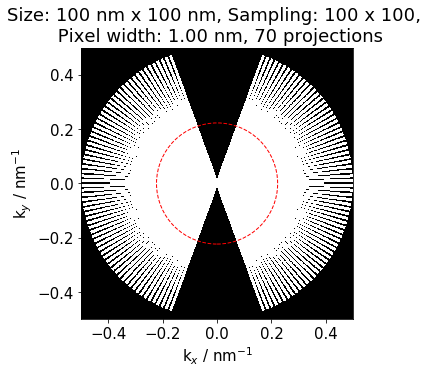

In [509]:
%matplotlib inline
fim = plot_slices2(n=100,amax=70,num=70)

--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0


Text(0, 0.5, 'k$_y$ / nm$^{-1}$')

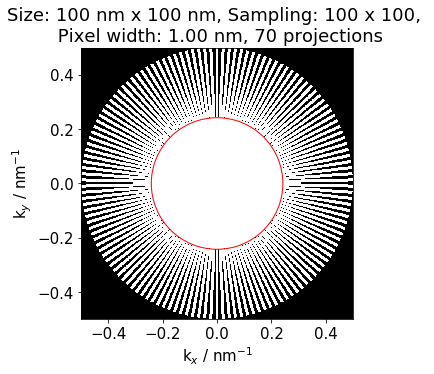

In [231]:
t = 1e-8
fim = plot_slices2(n=100,amax=90,num=70)

#binarise
fim2 = (fim > t).astype(np.int_)
d = reduced_crowther(fim2)
extent = [-.5,.5,-.5,.5]
plt.imshow(fim2,cmap='Greys_r',extent=extent)
c = plt.Circle([0,0],radius=1/d,color='r',fill=False)
ax = plt.gca()
ax.add_patch(c)
plt.xlabel('k$_x$ / nm$^{-1}$')
plt.ylabel('k$_y$ / nm$^{-1}$')



In [189]:


d = 100
n = 100
N = 1000

def reduced_crowther(fim2,d=100,n=100,N=1000):
    dim = int(np.shape(fim2)[0]/2)
    rpx = d/n
    fpx = 1/rpx / N
    crow2 = 0
    class GetOutOfLoop( Exception ):
        pass

    try:
        for rad_px in range(1,dim):
            for i in range(rad_px):
                for j in range(rad_px):
                    if i**2 + j**2 < rad_px**2:
                        if fim2[dim+i,dim+j] == 1 and fim2[dim-i,dim-j] == 1 and fim2[dim+i,dim-j] == 1 and fim2[dim-i,dim+j] == 1:
                            pass
                        else:
                            #print(rad_px,i,j)#,fim2[dim+i,dim+j])
                            crow2 = 1/(rad_px*fpx)
                            #print(dim+i,dim+j)
                            raise getOutOfLoop
    except:
        pass
    return crow2

reduced_crowther(fim2)

55.55555555555555

In [197]:
# slices in FS
n=100
d=100

all_ds = []
for num in [10,20,30,40,50,60,70]:
    ds = []
    for amax in [10,20,30,40,50,60,70,80,90]:
        fim = plot_slices2(n=100,d=100,amax=amax,num=num)
        plt.close()
        #binarise
        t = 1e-8
        fim2 = (fim > t).astype(np.int_)
        d = reduced_crowther(fim2,d=100,n=100,N=1000)
        ds.append(d)
    all_ds.append(ds)

--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not h

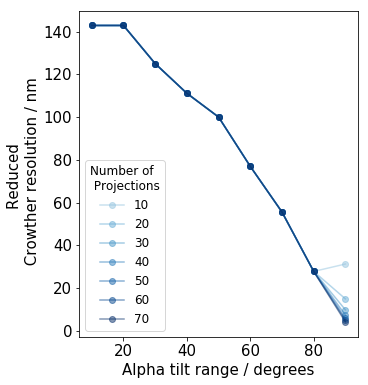

In [236]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Blues')
plt.figure(figsize=(5,6))
for i, num in enumerate([10,20,30,40,50,60,70]):
    c = cmap((i+1)/7*.7+.3)
    plt.plot([10,20,30,40,50,60,70,80,90],all_ds[i],'o-',label=num,color=c,alpha=.5)
    plt.xlabel('Alpha tilt range / degrees')
    plt.ylabel('Reduced \n Crowther resolution / nm')
    
leg = plt.legend(title='Number of \n Projections',fontsize=12,loc='lower left')
leg.get_title().set_fontsize('12')

In [220]:
all_ds[2]

[142.85714285714286,
 142.85714285714286,
 125.0,
 111.1111111111111,
 100.0,
 76.92307692307692,
 55.55555555555555,
 27.777777777777775,
 9.80392156862745]

In [333]:
import imageio

#sizes = np.linspace(15,500,num=30)
#nums = np.linspace(1,100,num=30)
res = np.linspace(25,500,num=30)
fpaths = []
for x in res:
    x = int(x)
    fpath = r'Output_Data/slices/res/%i.png' % x
    plot_slices(n=x,save_path=fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'Output_Data/slices/res.gif',images)

In [2]:
def sin_im(xFreq=10,yFreq=0,lims=[100,50],scales=[1,1]):
    """ Note that the frequency is relative to the size of the image
    i.e. xfreq 10 for an image 100 nm wide will peak at 0.1 nm^-1
    i.e. it will fit xfreq oscillations into lim space"""
    xFreq*=1/lims[0]#scales[0]
    yFreq*=1/lims[1]#scales[1]
    x = np.linspace(0, lims[0], int(lims[0]/scales[0]))
    y = np.linspace(0, lims[1], int(lims[1]/scales[1]))
    X,Y = np.meshgrid(x,y)
    im = np.exp(2j * np.pi * Y * yFreq) * np.exp(2j * np.pi * X * xFreq)
    return np.real(im)
    
def hamming_2d(im):
    s = np.shape(im)
    h1 = np.hamming(s[0])
    h2 = np.hamming(s[1])
    ham2d = (np.outer(h1,h2))
    return im*ham2d


# plt.show()

# f,axs = plt.subplots(nrows=3,ncols=3)
# for i in range(3):
#     for j in range(3):
#         axs[i,j].imshow(im)
#         axs[i,j].axis('off')
# #plt.tight_layout()
# plt.subplots_adjust(wspace=0.08, hspace=-0.5)

(-0.5, 99.5, 99.5, -0.5)

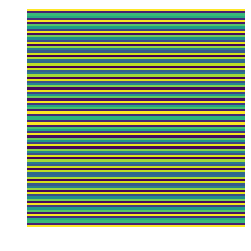

In [358]:
# im = np.ones((100,100))
# im = hamming_2d(im)
im = sin_im(xFreq=0,yFreq=0.4*100,lims=[100,100],scales=[1,1])
plt.imshow(im)
plt.axis('off')

In [335]:
def plot_FFT(im,scale=1,truncate=None,log=False,ax=None,ds=None,ns=None, lmin = None):
    """ Calculate and plot the FFt of an image
    To see fine details, try truncating the maximum value,
    plotting in log form, and scaling the data."""
    if ax==None:
        fig = plt.figure()
        ax = plt.gca()
    # https://stackoverflow.com/questions/39760962/how-to-normalise-a-2d-fft-plot-to-the-right-frequency-matlab
    F = np.fft.fft2(im)
    
    # A peculiarity of the DFT is that frequencies increase up to N/2
    # And then decrease from N/2 to N. This is a 'reflection' and is
    # to do with Nyquist sampling frequencies. We instead shift
    # such that the low frequencies are the in centre and we see a
    # range from -N/2 to N/2
    # We can do this because DFTs assume periodicity of the signal
    F_shift = np.fft.fftshift(F)
    
    # We want the amplitude spectrum which is the magnitude
    # we may also which to scale this to see more clearly
    F_shift_abs = abs(F_shift) * scale
    
    # showing on a log scale can show features more clearly
    if log == True:
        F_shift_abs = np.log(abs(F_shift)) * scale
    
    # truncating the maximum value can show more clearly
    if truncate == None:
        truncate = np.max(F_shift_abs)
        
    # establish spatial frequency axes
    
    # get image length d in nm and number of pixels n
    if ds == None:
        dy,dx = np.shape(im) # image length in nm
        nx,ny = dx,dy # number of samples along length
        
        ds,ns = [dx,dy], [nx,ny]
    dx,dy = ds
    nx,ny = ns  
    # get pixel width in real space in nm
    l_im_x = dx/nx
    l_im_y = dy/ny
    
    fx = 1/l_im_x * np.arange(-nx/2,nx/2-1)/nx
    fy = 1/l_im_y * np.arange(-ny/2,ny/2-1)/ny
    
    # get MINIMUM pixel width in real space in nm (at highst res)
    if lmin == None:
        lmin = [l_px_x,l_px_y]
        
    l_im_min_x,l_im_min_y = lmin
    
    # calculate pixel width in fourier space
    l_ft_x = 1/(l_im_x * nx) 
    l_ft_y = 1/(l_im_y * ny) 
    
    # calculate total number of pixels needed to reach highest resolution in FT
    Nx = 1/(l_im_min_x*l_ft_x)
    Ny = 1/(l_im_min_y*l_ft_y)
    
    # missing pixels
    missing_x = Nx - nx
    missing_y = Ny - ny
    
    fft = np.pad(F_shift_abs,[(int(missing_y/2), int(missing_y/2)), (int(missing_x/2), int(missing_x/2))])
    
    # left right bottom top
    #extent = [np.min(fx),np.max(fx),np.min(fy),np.max(fy)]
    #extent = [-1/l_im_x/2, 1/l_im_x/2, -1/l_im_y/2,1/l_im_y/2]
    extent = [-1/l_im_min_x/2,1/l_im_min_x/2,-1/l_im_min_x/2,1/l_im_min_x/2] 
    
    #print(l_ft_x,l_ft_y)
    imshow = ax.imshow(fft,vmax=truncate,cmap='Greys_r',extent=extent)
    plt.colorbar(imshow,fraction=0.046, pad=0.04)
    ax.set_title('Fourier space',fontsize=20)
    
    ax.set_xlabel('k$_x$ / nm$^{-1}$',fontsize=15)
    ax.set_ylabel('k$_y$ / nm$^{-1}$',fontsize=15)

In [181]:
%matplotlib
%matplotlib qt

Using matplotlib backend: Qt5Agg


Image dimensions: 287 x 84 nm 	 Image sampling: 212 x 76


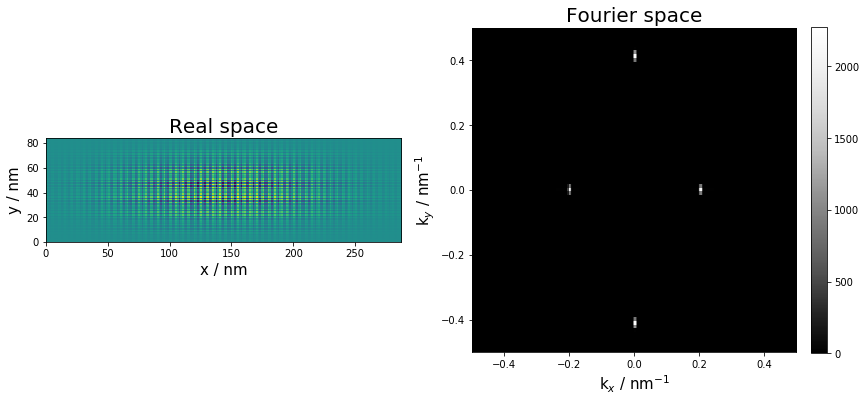

In [343]:
%matplotlib inline

# max sampling = minimum pixel length in nm
lmin = 1

# image lengths in nm
dx = 287
dy = 84

# image sampling no.s
nx = 212#dx/(lmin*1)
ny = 76#dy/(lmin*1)

# Create image
# Freq is f * d since Freq is the number of oscillations over the image
# so for a frequency of f, you need f*d oscillations per image 
im1 = sin_im(xFreq=.2*dx,yFreq=0*dy,lims=[dx,dy],scales=[dx/nx,dy/ny])
im2 = sin_im(xFreq=0*dx,yFreq=.4*dy,lims=[dx,dy],scales=[dx/nx,dy/ny])
im = im1+im2
im = hamming_2d(im)

# Plot image
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ly,lx = np.shape(im)
imshow1 = axs[0].imshow(im,extent=[0,dx,0,dy],cmap='viridis')
axs[0].set_title('Real space',fontsize=20)
axs[0].set_xlabel('x / nm',fontsize=15)
axs[0].set_ylabel('y / nm',fontsize=15)

# Plot FFT
plot_FFT(im,scale=1,truncate = None, log=False,ax=axs[1],ds=[dx,dy],ns=[nx,ny], lmin=[lmin,lmin])

print('Image dimensions:',dx,'x',dy,'nm \t Image sampling: %i x %i' %(nx,ny))

In [27]:
import numpy as np

xs = np.linspace(-100,100,10)
ys = np.linspace(-100,100,20)
zs = np.linspace(-100,100,30)

X,Y,Z = np.meshgrid(xs,ys,zs, indexing='ij')

P = np.zeros_like(X)

# for i in range(10):
#     for j in range(20):
#         for k in range(30):
#             if X[]

In [22]:
P.shape

(10, 20, 30)

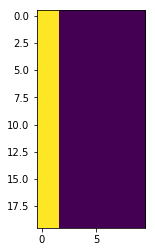

In [29]:
from matplotlib import pyplot as plt
P[0:2,:,0] = 1
plt.imshow(P[:,:,0].T)

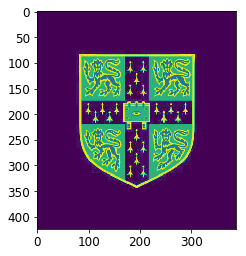

In [28]:
import cv2

plt.imshow(im)

(10, 100)

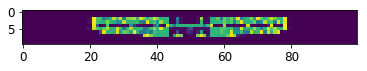

In [33]:
im2 = cv2.resize(im,dsize=(100,10))

plt.imshow(im2)
np.shape(im2)

In [4]:
import multi_axis
import astra       

In [243]:
angles = multi_axis.generate_angles()
vectors = multi_axis.generate_vectors(angles)

raw_data = np.ones((100,40,100))

In [254]:
# 3D
proj_geom = astra.create_proj_geom('parallel3d_vec',np.shape(raw_data)[0],np.shape(raw_data)[2],np.array(vectors))
vol_geom = astra.creators.create_vol_geom(np.shape(raw_data)[0], np.shape(raw_data)[0],np.shape(raw_data)[2]) 
proj_id = astra.create_projector('cuda3d', proj_geom, vol_geom) 
matrix_id = astra.projector.matrix(proj_id) 
W = astra.matrix.get(matrix_id)

In [515]:
np.shape(W)

(1500, 400)

In [53]:
def hacky_res_shit_2d(amax,n_tilt,n,d = 100):
    # calculate projection matrix
    proj_geom = astra.create_proj_geom('parallel',1,n,np.linspace(-amax,amax,n)*np.pi/180) 
    vol_geom = astra.creators.create_vol_geom(n,n) 
    proj_id = astra.create_projector('line', proj_geom, vol_geom) 
    matrix_id = astra.projector.matrix(proj_id) 
    W = astra.matrix.get(matrix_id)
    
    # calculate eigenvalues of normal matrix
    N = np.matmul(W.A.T,W.A)
    ev = np.linalg.eig(N)[0]
    ev = np.reshape(ev,(n,n),order='F')
    
    # find where value of 1/ev exceeds 1
    imbin = (1/np.abs(ev) > 1).astype(np.int_)
    
    # find index where >1/3 of data is exceeding 1
    s = np.sum(imbin,axis=0)
    imax = np.where(s>np.shape(imbin)[0]/3)[0][0]
    print(imax)
    
    # plot if you want
    plt.figure()
    plt.imshow(imbin,extent=[1,n,1,n])
    plt.plot([imax,imax],[1,n],'r--')
    
    plt.figure()
    plt.plot(np.arange(1,n+1),1/np.sum(ev,axis=0),'-o')
    plt.ylim([0,1])
    
    # convert to a resolution
    max_rad = ((1/d)*(n/2)) * imax/(n)
    
    # plot resolution
#     plt.figure()
#     plot_slices2(n=n,amax=amax,num=n_tilt)
#     c = plt.Circle([0,0],radius=((1/d)*(n/2)) * 15/(n),color='r',fill=False)
#     ax = plt.gca()
#     ax.add_patch(c)
    
    return max_rad

12


0.060000000000000012

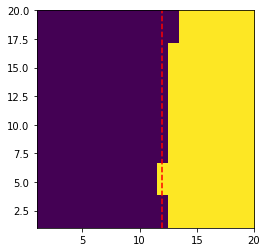

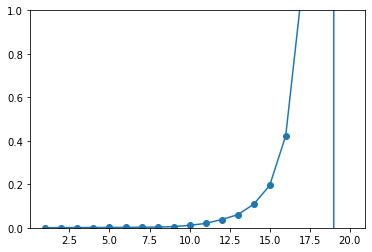

In [54]:
hacky_res_shit_2d(45,19,20)

In [57]:
# 2D
proj_geom = astra.create_proj_geom('parallel',1,15,np.linspace(-45,45,19)*np.pi/180) 
vol_geom = astra.creators.create_vol_geom(20,20) 
proj_id = astra.create_projector('line', proj_geom, vol_geom) 
matrix_id = astra.projector.matrix(proj_id) 
W = astra.matrix.get(matrix_id)
np.shape(W)

(285, 400)

(-0.5, 399.5, 284.5, -0.5)

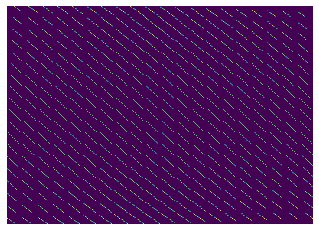

In [58]:
plt.imshow(W.A)
plt.axis('off')

(-0.5, 19.5, 19.5, -0.5)

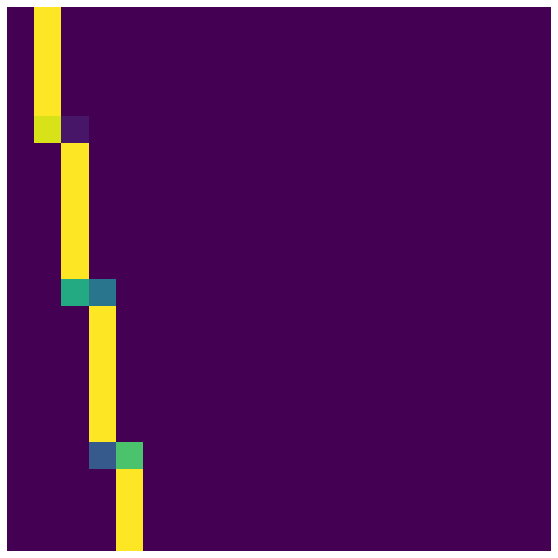

In [59]:
plt.figure(figsize=(16,10))
plt.imshow(W[15+5*30].A.reshape(20,20))
plt.axis('off')


In [530]:
np.linspace(-45,45,19)*np.pi/180

array([-0.78539816, -0.6981317 , -0.61086524, -0.52359878, -0.43633231,
       -0.34906585, -0.26179939, -0.17453293, -0.08726646,  0.        ,
        0.08726646,  0.17453293,  0.26179939,  0.34906585,  0.43633231,
        0.52359878,  0.61086524,  0.6981317 ,  0.78539816])

In [60]:
N = np.matmul(W.A.T,W.A)

In [61]:
N_inv = np.linalg.inv(N)

In [62]:
ev = np.linalg.eig(N)[0] # slow took about 10 minutes

In [63]:
np.shape(ev)

(400,)

In [64]:
ev2 = np.reshape(ev,(20,20),order='C')

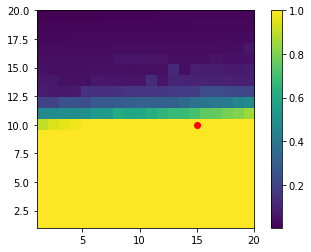

In [65]:
1/ev2
#plt.imshow(np.log10(abs(ev2)),vmin=0)
plt.imshow(1/np.abs(ev2),vmax=1,extent=[1,20,1,20])
plt.colorbar()
plt.plot([15],[10],'ro')

(-0.1, 1.1)

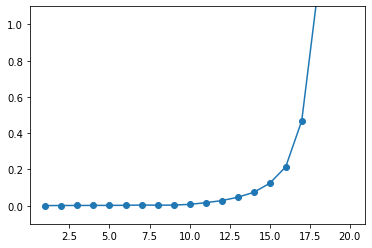

In [34]:
plt.plot(np.arange(1,21),1/np.sum(ev2,axis=1),'-o')
plt.ylim([-0.1,1.1])

25

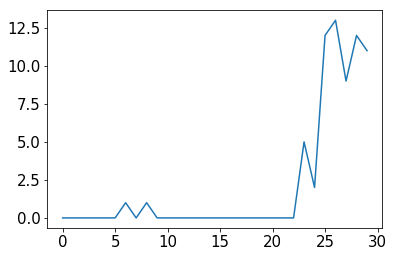

In [485]:
import scipy
im = np.sum(1/np.abs(ev2),axis=0)
imbin = (1/np.abs(ev2) > 1).astype(np.int_)
s = np.sum(imbin,axis=0)
plt.plot(s)
np.where(s>np.shape(imbin)[0]/3)[0][0]

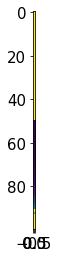

In [346]:
#plt.imshow(abs(ev2[:,0:1]),vmax=1)
plt.imshow(1/np.fft.fftshift(abs(ev2[:,0:1])),vmax=1)

--5.0-- should be >=10, else your FS display resolution is not high enough)
4 5.0


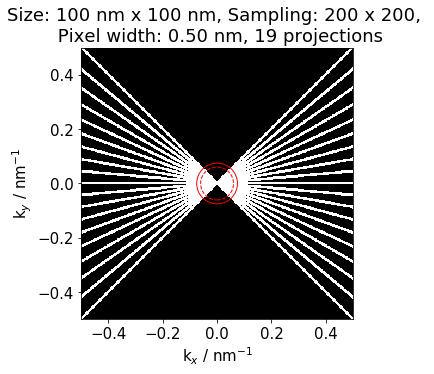

In [510]:
%matplotlib inline
n = 200
plot_slices2(n=n,amax=45,num=19)
d = 100

c = plt.Circle([0,0],radius=((1/d)*(n/2)) * 15/(n),color='r',fill=False)
ax = plt.gca()
ax.add_patch(c)


In [417]:
%matplotlib qt
%matplotlib qt
plt.figure()
plt.show()

In [420]:
%matplotlib inline

In [501]:
n = 50
d = 100
((1/d)*(n/2)) * 15/(n)

0.075

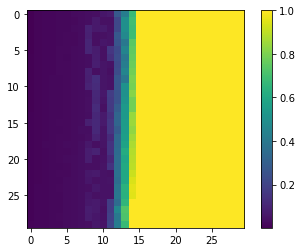

In [75]:
amax = 45 # +- alpha tilt range
ntilt = 19 # number of projections
ndet = 30 # number of detector pixels

# Define tilt series angles
angles = np.linspace(-amax,amax,ntilt)*np.pi/180

# calculate projection matrix
proj_geom = astra.create_proj_geom('parallel',1,ndet,angles) 
vol_geom = astra.creators.create_vol_geom(ndet,ndet) 
proj_id = astra.create_projector('line', proj_geom, vol_geom) 
matrix_id = astra.projector.matrix(proj_id) 
W = astra.matrix.get(matrix_id)

# calculate normal matrix
N = np.matmul(W.A.T,W.A)

# calculate eigenvalues of normal matrix
ev = np.linalg.eig(N)[0]

# shape eigenvalues into a square matrix
ev = np.reshape(ev,(ndet,ndet),order='F')

# view '1/eigenvalue', with cutoff above 1
plt.imshow(1/np.abs(ev),vmax=1)
plt.colorbar()

--33.3-- should be >=10, else your FS display resolution is not high enough)
32 33.333333333333336


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

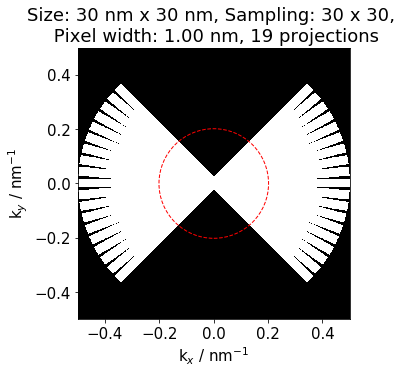

In [80]:
plot_slices2(amax=45,num=19,n=30,d=30)

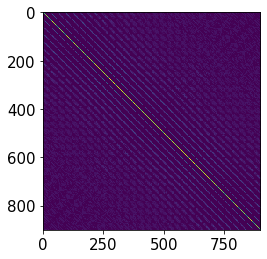

In [81]:
plt.imshow(N)

In [82]:
np.shape(N)

(900, 900)